# Data Preparation

In [34]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import numpy as np

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

### Defining a base neural network

In [35]:
class BaseNeuralNetwork(nn.Module):
    def __init__(self):
        super(BaseNeuralNetwork, self).__init__()
        # Flatten inputs
        #self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.Linear(26,416), 
            nn.ReLU(),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = BaseNeuralNetwork()

In [102]:
class BaseNeuralNetwork(nn.Module):
    def __init__(self):
        super(BaseNeuralNetwork, self).__init__()
        # Flatten inputs
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
                nn.Linear(28 * 28, 512),
                nn.ReLU(),
                nn.Linear(512,256),
                nn.ReLU(),
                nn.Linear(256,128),
                nn.ReLU(),
                nn.Linear(128,64),
                nn.ReLU(),
                nn.Linear(64,32),
                nn.ReLU(),
                nn.Linear(32,16),
                nn.ReLU(),
                nn.Linear(16,10)
            
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = BaseNeuralNetwork()

In [103]:
def train_loop(dataloader, model, loss_fn, optimizer, prin = False):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation (always in three steps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0 and prin:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return 100*(1-correct)

### Learning

In [104]:
# Hyperparameters
learning_rate = 0.001
batch_size = 256
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [105]:
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [106]:
### Training
error = []
for t in range(epochs):
    print(f"Epoch {t+1}-----------------")
    #Use train_loop and test_loop functions
    train_loop(train_dataloader, model, loss_fn, optimizer)
    x = test_loop(test_dataloader, model, loss_fn)
    error.append(x)
print("Done!")


Epoch 1-----------------
Test Error: 
 Accuracy: 79.7%, Avg loss: 0.563955
Epoch 2-----------------
Test Error: 
 Accuracy: 83.4%, Avg loss: 0.470518
Epoch 3-----------------
Test Error: 
 Accuracy: 84.4%, Avg loss: 0.433033
Epoch 4-----------------
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.406194
Epoch 5-----------------
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.389415
Epoch 6-----------------
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.375461
Epoch 7-----------------
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.370210
Epoch 8-----------------
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.382567
Epoch 9-----------------
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.367546
Epoch 10-----------------
Test Error: 
 Accuracy: 87.3%, Avg loss: 0.360022
Done!


In [107]:
class BaseNeuralNetworkRS(nn.Module):
    def __init__(self):
        super(BaseNeuralNetworkRS, self).__init__()
        # Flatten inputs
        self.flatten = nn.Flatten()

        self.relu = nn.ReLU()

        self.start = nn.Linear(28 * 28, 512)
        self.lin1 = nn.Linear(512,256)
        self.lin2 = nn.Linear(256,128)
        self.lin3 = nn.Linear(128,64)
        self.lin4 = nn.Linear(64,32)
        self.lin5 = nn.Linear(32,16)
        self.fc = nn.Linear(16,10)
        
    def proj(self, x, size):
        indice = np.linspace(0, size - 1, size).tolist()
        indice = torch.tensor([int(x) for x in indice])
        
        return torch.index_select(x, 1, indice)


    def forward(self, x):
        x = self.flatten(x)
        f = 0
        x = self.relu(self.start(x)) + f*self.proj(x, 512)
        x = self.relu(self.lin1(x)) + f*self.proj(x, 256)
        x = self.relu(self.lin2(x)) + f*self.proj(x, 128)
        x = self.relu(self.lin3(x)) + f*self.proj(x, 64)
        x = self.relu(self.lin4(x)) + f*self.proj(x, 32)
        x = self.relu(self.lin5(x)) + f*self.proj(x, 16)
        x = self.relu(self.fc(x))

        return x

modelRS = BaseNeuralNetworkRS()

In [108]:
### Training
error = []
for t in range(epochs):
    print(f"Epoch {t+1}-----------------")
    #Use train_loop and test_loop functions
    train_loop(train_dataloader, modelRS, loss_fn, optimizer)
    x = test_loop(test_dataloader, model, loss_fn)
    error.append(x)
print("Done!")


Epoch 1-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Epoch 2-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Epoch 3-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Epoch 4-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Epoch 5-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Epoch 6-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Epoch 7-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Epoch 8-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Epoch 9-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Epoch 10-----------------
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.782022
Done!


[24.750000000000007, 17.830000000000002, 15.239999999999998, 14.459999999999996, 14.359999999999996, 13.81, 13.770000000000005, 13.090000000000002, 12.9, 12.490000000000002]


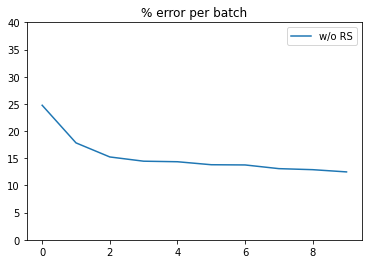

In [60]:
import copy

error_wo = copy.deepcopy(error)

plt.plot(error_wo, label = "w/o RS")
plt.legend()
plt.title("% error per batch")
plt.ylim((0, 40))
plt.show()

error_without = [24.750000000000007, 17.830000000000002, 15.239999999999998, 14.459999999999996, 14.359999999999996, 13.81, 13.770000000000005, 13.090000000000002, 12.9, 12.490000000000002]

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = nn.ReLU(inplace=True)(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU(inplace=True)(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avg_pool = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.ReLU(inplace=True)(self.bn(self.conv(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def ResNet50():
    return ResNet(ResidualBlock, [3, 4, 6, 3])

model = ResNet50()


In [16]:
### Training
for t in range(epochs):
    print(f"Epoch {t+1}-----------------")
    #Use train_loop and test_loop functions
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1-----------------


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x256 and 512x10)